In [17]:
#import packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import tqdm as loadbar
import glob
import os

#### Data loading

In [18]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

In [19]:
#import cars vs non cars seperately
base_dir = "../../../../../Volumes/Solix/Datasets/car-vs-noneCar/vehicles/"

image_types = os.listdir(base_dir)
cars=[]

for im_type in image_types:
    cars.extend(glob.glob(base_dir+im_type+'/*'))
    
    
print('number of cars: ' + str(len(cars)))

with open("cars.txt",'w') as f:
    for fn in cars:
        f.write(fn+'\n')

base_dir = "../../../../../Volumes/Solix/Datasets/car-vs-noneCar/non-vehicles/"
image_types = os.listdir(base_dir)
not_cars=[]

for im_type in image_types:
    not_cars.extend(glob.glob(base_dir+im_type+'/*'))


print('number of non-cars: ' + str(len(not_cars)))

with open("notcars.txt",'w') as f:
    for fn in cars:
        f.write(fn+'\n')

number of cars: 8792
number of non-cars: 8968


#### Histogram of Oriented Gradients (HOG)

In [20]:
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [21]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

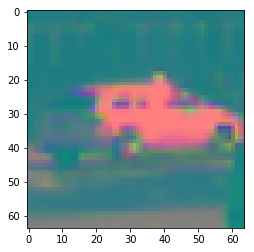

In [42]:
%matplotlib inline
random = np.random.randint(0,len(cars))
test_image_car = mpimg.imread(cars[random])
YCrCb_image_car = convert_color(test_image_car)
plt.imshow(YCrCb_image_car)

In [29]:
test_bin_car = bin_spatial(test_image_car)
hog_feature = get_hog_features(test_bin_car,9,8,2,vis=False)

(array([ 1.,  0.,  0., ...,  0.,  0.,  1.]),
 array([ 0.00059025,  0.00059099,  0.00059173, ...,  0.002864  ,
         0.00286474,  0.00286548]),
 <a list of 3072 Patch objects>)

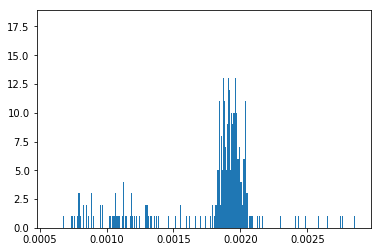

In [36]:
plt.hist(test_bin_car/255,len(test_bin_car))